In [1]:
import sisl
import pandas as pd
import csv
import ast

from pathlib import Path
from tqdm import tqdm

# Read the dataset using SISL
path= Path('../dataset')

# Get all subdirectories (atom types)
n_atoms_paths = list(path.glob('*/'))

# Then all structures
i=0
structure_paths = [list(n_atoms_paths[i].glob('*/')) for i in range(len(n_atoms_paths))]
structure_paths = [item for sublist in structure_paths for item in sublist]

# Create Padnas DataFrame
columns = ["n_atoms", "atomic_number", "atomic_symbol", "atomic_positions", "lattice_nsc", "lattice_origin", "lattice_vectors", "boundary_condition"]
df = pd.DataFrame(columns=columns)
for structure in tqdm(structure_paths):
    file = sisl.get_sile(structure / "aiida.HSX")
    geometry = file.read_geometry()
    lattice_vectors = geometry.lattice

    # Get atom symbols
    atomic_symbols = []
    for atom in geometry.atoms:
        atomic_symbols.append(atom.symbol)

    row_dict = {
        "n_atoms": len(geometry),
        "atomic_number": geometry.atoms.Z,
        "atomic_symbol": atomic_symbols,
        "atomic_positions": geometry.xyz,
        "lattice_nsc": lattice_vectors.nsc,
        "lattice_origin": lattice_vectors.origin,
        "lattice_vectors": lattice_vectors.cell,
        "boundary_condition": lattice_vectors.boundary_condition
    }

    df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
    
df.to_pickle("dataset.pkl")

def flatten(xss):
    return [x for xs in xss for x in xs]

0it [00:00, ?it/s]


In [22]:
# Read the dataset back
df = pd.read_pickle("dataset.pkl")
df.tail()

,n_atoms,atomic_number,atomic_symbol,atomic_positions,lattice_nsc,lattice_origin,lattice_vectors,boundary_condition
1306,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [3.2873668683...","[5, 5, 7]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1307,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.2881431...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1308,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [1.938954614,...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1309,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [2.3964413432...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1310,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.3007791...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"


In [23]:
# Print some stats.

# Unique atom types
unique_atom_types = []
for row in df["atomic_number"]:
    for atom_type in row:
        if atom_type not in unique_atom_types:
            unique_atom_types.append(atom_type)

# Unique atom symbols
unique_atom_symbols = []
for row in df["atomic_symbol"]:
    for atom_type in row:
        if atom_type not in unique_atom_symbols:
            unique_atom_symbols.append(atom_type)

print(f"Analyzed {len(df)} elements. Found:")
print(unique_atom_types)
print(unique_atom_symbols)

Analyzed 1311 elements. Found:
[7, 6, 5]
['N', 'C', 'B']


There are some carbons. How many of them?

In [24]:
n_carbon = df["atomic_number"].apply(lambda x: 6 in x).sum()
print(f"There are {n_carbon}/{len(df)} samples with Carbon atoms.")

There are 682/1311 samples with Carbon atoms.


This is more than half the dataset. Not negligible.

What is the distribution of the carbon atoms?

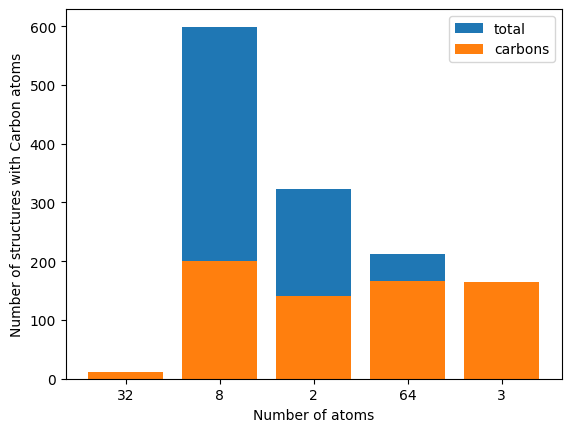

In [25]:
import matplotlib.pyplot as plt

n_atoms = df["n_atoms"].drop_duplicates()
counts = [df[df["n_atoms"] == i]["atomic_number"].apply(lambda x: 6 in x).sum() for i in n_atoms.to_list()]
x_labels = [str(i) for i in n_atoms.to_list()]

totals = [(df["n_atoms"] == i).sum() for i in n_atoms.to_list()]
plt.bar(x_labels, totals, label="total")
plt.bar(x_labels, counts, label="carbons")
plt.xlabel("Number of atoms")
plt.ylabel("Number of structures with Carbon atoms")
plt.legend()


In [13]:
# Let's try to exclude the carbons

parent_path = Path('../dataset')
n_atoms_paths = list(parent_path.glob('*/'))

paths = []
for n_atoms_path in n_atoms_paths:
    structure_paths = list(n_atoms_path.glob('*/'))

    structure_paths_nocarbon = structure_paths
    for structure_path in structure_paths:
        file = sisl.get_sile(structure_path / "aiida.fdf")
        geometry = file.read_geometry()
        zs = geometry.atoms.Z
        if 6 in zs:
            # Exclude this structure
            exclude = structure_path
            structure_paths_nocarbon = [x for x in structure_paths_nocarbon if x != exclude]


    paths.append(structure_paths_nocarbon)
paths = flatten(paths)

In [14]:
paths

[PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/6d1a-578f-478c-a320-d8be012039e6'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/6d69-12f4-459d-ba19-f7951a3299dc'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/b908-9d2a-4e27-96e6-c1f6f75a76f7'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/66ea-aa33-4cd1-a2b0-7f530e6788d4'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/a4f7-5d3f-4e50-9eda-87df3bf9ba58'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/0c9b-0f56-4c21-b69b-6147764120fa'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/8f7b-867e-4e9d-a027-997b50ee2ba6'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/91dc-c45e-4096-8e0e-04e28f21a44c'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/cd6e-7357-4868-b521-63e9bad68413'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/c580-0447-4510-bf6d-8dc278a7c3cf'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/427a-33e4-40d4-9fbf-7d55d341bc33'),
 PosixPath('../dataset/SHARE_OUTPUTS_2_ATOMS/d2e2-51e3-40ca-a3bd-4dcb70c095c2'),
 PosixPath('../dataset/SHARE

100%|██████████| 183/183 [00:00<00:00, 1030.05it/s]


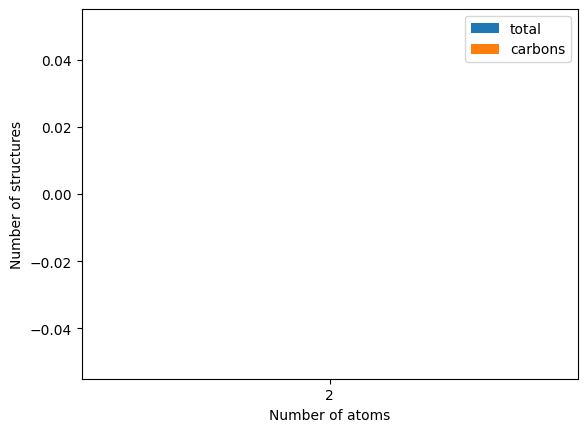

In [15]:
df_nocarbon = pd.DataFrame(columns=["n_atoms", "atomic_number"])
for path in tqdm(paths):
    file = sisl.get_sile(path / "aiida.HSX")
    geometry = file.read_geometry()
    lattice_vectors = geometry.lattice


    row_dict = {
        "n_atoms": len(geometry.atoms.Z),
        "atomic_number": geometry.atoms.Z,
    }

    df_nocarbon = pd.concat([df_nocarbon, pd.DataFrame([row_dict])], ignore_index=True)

import matplotlib.pyplot as plt

n_atoms = df_nocarbon["n_atoms"].drop_duplicates()
counts = [df_nocarbon[df_nocarbon["n_atoms"] == i]["atomic_number"].apply(lambda x: 6 in x).sum() for i in n_atoms.to_list()]
x_labels = [str(i) for i in n_atoms.to_list()]

totals = [(df["n_atoms"] == i).sum() for i in n_atoms.to_list()]
plt.bar(x_labels, totals, label="total")
plt.bar(x_labels, counts, label="carbons")
plt.xlabel("Number of atoms")
plt.ylabel("Number of structures")
plt.legend()

In [16]:
df_nocarbon

,n_atoms,atomic_number
0,2,"[5, 5]"
1,2,"[7, 7]"
2,2,"[5, 5]"
3,2,"[5, 5]"
4,2,"[5, 5]"
...,...,...
178,2,"[5, 5]"
179,2,"[5, 5]"
180,2,"[5, 5]"
181,2,"[7, 7]"


In [10]:
totals

[0]

Text(0.5, 1.0, 'Distribution of the dataset')

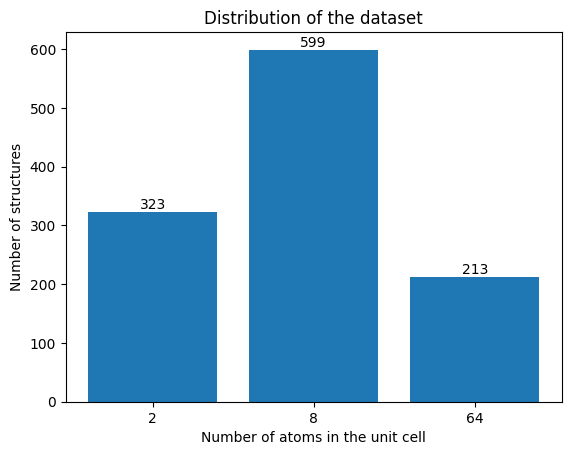

In [100]:
# Fast solution to ordering issue

x = ["2", "8", "64"]
y = [323, 599, 213]

fig, ax = plt.subplots()
bars = ax.bar(x, y)
ax.bar_label(bars)

plt.xlabel("Number of atoms in the unit cell")
plt.ylabel("Number of structures")
plt.title("Distribution of the dataset")

In [17]:
# Por qué siguen habiendo carbons? --> Ya no! :D
for i, path in tqdm(enumerate(paths)):
    file = sisl.get_sile(path / "aiida.HSX")
    geometry = file.read_geometry()
    if 6 in geometry.atoms.Z:
        print(f"Found a Carbon in path {i}")
        break
print("Finished loop")

183it [00:00, 1306.34it/s]

Finished loop


In [18]:
# Let's save those paths with no carbons.

# Get unique X_ATOMS
unique_x_atoms = []
for path in paths:
    x_atoms = path.parts[-2]
    if x_atoms not in unique_x_atoms:
        unique_x_atoms.append(x_atoms)
    
print(unique_x_atoms)

# Create children folders
parent_dir = Path("../dataset_nocarbon")
children_dirs = [parent_dir / unique_x_atoms_i for unique_x_atoms_i in unique_x_atoms]
for child_dir in children_dirs:
    child_dir.mkdir(exist_ok=True, parents=True)

# Create a list with as many lists as elements in unique_x_atoms
nocarbon_structures = [[] for _ in children_dirs]

# Classify the sturctures
for path in paths:
    for i, child_dir in enumerate(children_dirs):
        if child_dir.parts[-1] == path.parts[-2]:
            nocarbon_structures[i].append(path.parts[-1])
    
print(nocarbon_structures)

# Save them in their respective folder
for i, structures in enumerate(nocarbon_structures):
    filepath = children_dirs[i] / "structures.txt"
    with open(filepath, "w") as f:
        f.write("\n".join(structures))

print("Dataset saved!")
    

['SHARE_OUTPUTS_2_ATOMS']
[['6d1a-578f-478c-a320-d8be012039e6', '6d69-12f4-459d-ba19-f7951a3299dc', 'b908-9d2a-4e27-96e6-c1f6f75a76f7', '66ea-aa33-4cd1-a2b0-7f530e6788d4', 'a4f7-5d3f-4e50-9eda-87df3bf9ba58', '0c9b-0f56-4c21-b69b-6147764120fa', '8f7b-867e-4e9d-a027-997b50ee2ba6', '91dc-c45e-4096-8e0e-04e28f21a44c', 'cd6e-7357-4868-b521-63e9bad68413', 'c580-0447-4510-bf6d-8dc278a7c3cf', '427a-33e4-40d4-9fbf-7d55d341bc33', 'd2e2-51e3-40ca-a3bd-4dcb70c095c2', '2f5b-a12e-4508-aa48-cf355b2303e5', 'e9fa-338a-455e-b89b-e54a3e88dfdc', 'f42a-df85-4da8-9960-efbedeb2d8b1', '4cc1-6263-48b4-9a54-d06ac88f4c85', '02a4-2c2f-4381-b074-ee6aa682941f', '4130-44f6-445e-8a26-4f6afcdd73ea', '8da9-708f-4ce4-842c-40181e097f16', '8301-0bfc-40d7-9f86-53e2ed6270ad', '7eb6-b121-4101-8a46-627c7a95f3f9', '9b66-b574-4792-89d5-30f2717531d2', '8ff7-f30f-4735-b581-be52392a2375', 'af08-63de-4132-b743-85aba30f078b', 'b684-4f57-474b-9762-b3416b5e7985', '6ab1-b9ab-4faa-9c05-0a6871bfa641', 'ce81-05d6-40c9-8c2b-7a586d09140c', 

In [32]:
#Play with strings
[int(Path(p).stem.split('_')[2]) for p in unique_x_atoms]

[8, 2, 64]

# Removing the B-B and N-N bonds

In [33]:
def write_structures_paths(structures_paths, filepath):
    with open(filepath, "w") as f:
        f.write("\n".join(structures_paths))

def read_structures_paths(filepath):
    with open(filepath, "r") as f:
        return f.read().splitlines()

In [34]:
# Load the nocarbon dataset:
# === List of paths to all structures ===
exclude_carbons = True
use_only = None


true_dataset_folder = Path('../dataset')
paths = []
if exclude_carbons:
    pointers_folder = Path('../dataset_nocarbon')

    # Use only determined subset of the dataset
    if use_only is not None:
        x_atoms_paths = [pointers_folder / f"SHARE_OUTPUTS_{n}" for n in use_only]
    else:
        x_atoms_paths = list(pointers_folder.glob('*/'))

    # Get all the structures
    filepath = "structures.txt"
    structures_paths = [[] for _ in x_atoms_paths]
    for i, x_atoms_path in enumerate(x_atoms_paths):
        structures = read_structures_paths(str(x_atoms_path / filepath))
        for structure in structures:
            structures_paths[i].append(x_atoms_path.parts[-1] +"/"+ structure)

    # Now we join them with the true parent folder
    for structures in structures_paths:
        for structure in structures:
            true_path = true_dataset_folder / structure
            paths.append(true_path)
        
else:  
    # Join all structures in the paths variable
    n_atoms_paths = list(true_dataset_folder.glob('*/'))
    for n_atoms_path in n_atoms_paths:
        structure_paths = list(n_atoms_path.glob('*/')) 
        for structure_path in structure_paths:
            paths.append(structure_path)

In [35]:
# Now we have to use sisl to read each structure and remove those B-B, N-N
for path in paths:
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    # ! Paso

# Where is the perfect crystal?

In [36]:
# === List of paths to all structures ===
import random
import yaml
from pathlib import Path
import sisl

def load_config(path="../config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)
    
def flatten(xss):
    return [x for xs in xss for x in xs]


parent_path = Path('../dataset')
n_atoms_paths = list(parent_path.glob('*/'))
paths = []
for n_atoms_path in n_atoms_paths:
    structure_paths = list(n_atoms_path.glob('*/'))
    paths.append(structure_paths)
paths = flatten(paths)

random.seed(42)
random.shuffle(paths)

# Search the crystal with no carbon atoms
count = 0
for path in paths:
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    if 6 not in geometry.atoms.Z and len(geometry.atoms.Z) == 8:
        print(f"Found a structure with no Carbon atoms: {path}")
        count += 1


print(f"Found {count} structures with no Carbon atoms.")

Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/74f6-ada8-4fcd-b69f-4ca3b0ddc30e
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/e84c-005c-4672-8d63-61876b569f15
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/8bfa-ca36-41f1-a041-14ad17494d59
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/5721-4d12-41f2-9f31-f7ee4fcf1096
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/807c-f894-4054-8ea4-da19dab86b43
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/4afc-f1fa-44f8-b159-50cdb0c2020b
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/8fb0-5187-4844-ab5b-f005e5a16194
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/085c-aa27-45ef-b057-4291c5609360
Found a structure with no Carbon atoms: ../dat

KeyboardInterrupt: 

In [ ]:
# Ok. There are several structures which are crystals with no Carbon atoms. Then, what is different in these structures?
paths = [
    Path("../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b"),
    Path("../dataset/SHARE_OUTPUTS_8_ATOMS/74f6-ada8-4fcd-b69f-4ca3b0ddc30e")
]

for i, path in enumerate(paths):
    print(f"Analyzing structure", i+1)
    file = sisl.get_sile(path / "aiida.fdf")
    file.plot.geometry(axes="xz")

Analyzing structure 1
Analyzing structure 2


In [ ]:
paths = [
    "../dataset/SHARE_OUTPUTS_8_ATOMS/d8ec-29f1-4d8d-a1b9-7496fa6135d1", # No
    "../dataset/SHARE_OUTPUTS_8_ATOMS/bca3-f473-4c5e-8407-cbdc2d7c68a1",
    "../dataset/SHARE_OUTPUTS_8_ATOMS/848a-19bd-414b-9ef2-40f39b1e2027",
    "../dataset/SHARE_OUTPUTS_8_ATOMS/7651-acf9-490f-81d6-a8a9d1c2de76",
]
paths = [Path(path) for path in paths]
files = [sisl.get_sile(path / "aiida.fdf") for path in paths]
[file.plot.geometry(axes="xyz").show() for file in files]

INFO	Task(Task-4) nodify.node.140328546243152:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328679967632:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328664455968:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546239120:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546087424:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546141776:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328679967632:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328664455968:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328546239120:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328546087424:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328546141776:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.

INFO	Task(Task-4) nodify.node.140328546662832:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546651456:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328702518976:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546658080:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328666116896:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546239072:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546651456:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328702518976:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328546658080:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328666116896:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328546239072:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.

INFO	Task(Task-4) nodify.node.140328528331792:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528102752:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528337984:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528075888:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528106112:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528114320:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528102752:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528337984:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528075888:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528106112:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528114320:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.

INFO	Task(Task-4) nodify.node.140328528816144:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528114848:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528078432:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528807840:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528345184:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328546435344:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140328528114848:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528078432:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528807840:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328528345184:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140328546435344:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.

[None, None, None, None]

In [ ]:
file = sisl.get_sile(paths[1] / "aiida.fdf")
file.plot.geometry(axes="xyz")

INFO	Task(Task-2) nodify.node.140418141863184:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.

INFO	Task(Task-2) nodify.node.140418142707184:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142862416:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142855936:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141857376:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418144270144:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141852624:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418144270672:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142736208:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142855936:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141857376:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418144270144:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

INFO	Task(Task-2) nodify.node.140418141863184:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.nod

# Where is the hBN?

In [ ]:
# Use only determined subset of the dataset
from pathlib import Path
use_only= ["2_ATOMS", "8_ATOMS"]
pointers_folder = Path('../dataset_nocarbon')
if use_only is not None:
    x_atoms_paths = [pointers_folder / f"SHARE_OUTPUTS_{n}" for n in use_only]

print(x_atoms_paths)

paths = []

# If you want no carbons


# Get all the structures
filepath = "structures.txt"
structures_paths = [[] for _ in x_atoms_paths]
for i, x_atoms_path in enumerate(x_atoms_paths):
    structures = read_structures_paths(str(x_atoms_path / filepath))
    for structure in structures:
        structures_paths[i].append(x_atoms_path.parts[-1] +"/"+ structure)

# Now we join them with the true parent folder
for structures in structures_paths:
    for structure in structures:
        true_path = true_dataset_folder / structure
        paths.append(true_path)

[PosixPath('../dataset_nocarbon/SHARE_OUTPUTS_2_ATOMS'), PosixPath('../dataset_nocarbon/SHARE_OUTPUTS_8_ATOMS')]


NameError: name 'true_dataset_folder' is not defined

# Plot B-N distribution per sample type

In [107]:
dataset_dir = Path("../dataset_nocarbon/SHARE_OUTPUTS_2_ATOMS")
dat2 = ["dataset/SHARE_OUTPUTS_2_ATOMS"/Path(path) for path in read_structures_paths(str(dataset_dir / f"structures.txt"))]

dataset_dir = Path("../dataset_nocarbon/SHARE_OUTPUTS_8_ATOMS")
dat8 = ["dataset/SHARE_OUTPUTS_8_ATOMS"/Path(path) for path in read_structures_paths(str(dataset_dir / f"structures.txt"))]

dataset_dir = Path("../dataset_nocarbon/SHARE_OUTPUTS_64_ATOMS")
dat64 = ["dataset/SHARE_OUTPUTS_64_ATOMS"/Path(path) for path in read_structures_paths(str(dataset_dir / f"structures.txt"))]

import numpy as np

n_B = 0
n_N = 0
for path in dat2:
    path = ".."/path
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    for Z in geometry.atoms.Z:
        if Z == 5:
            n_B += 1
        elif Z == 7:
            n_N += 1
        else:
            raise ValueError("WTF found a non B nor N atom")
        
type_count = {
    'Nitrogen': np.array([n_N]),
    'Boron': np.array([n_B]),
}

n_B = 0
n_N = 0
for path in dat8:
    path = ".."/path
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    for Z in geometry.atoms.Z:
        if Z == 5:
            n_B += 1
        elif Z == 7:
            n_N += 1
        else:
            raise ValueError("WTF found a non B nor N atom")
type_count["Boron"] = np.concatenate([type_count["Boron"], np.array([n_B])])
type_count["Nitrogen"] = np.concatenate([type_count["Nitrogen"], np.array([n_N])])

n_B = 0
n_N = 0
for path in dat64:
    path = ".."/path
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    for Z in geometry.atoms.Z:
        if Z == 5:
            n_B += 1
        elif Z == 7:
            n_N += 1
        else:
            raise ValueError("WTF found a non B nor N atom")
type_count["Boron"] = np.concatenate([type_count["Boron"], np.array([n_B])])
type_count["Nitrogen"] = np.concatenate([type_count["Nitrogen"], np.array([n_N])])

In [90]:
# Stack arrays to compute total per index
stacked = np.stack(list(type_count.values()))
totals = np.sum(stacked, axis=0)

# Avoid division by zero
totals_safe = np.where(totals == 0, 1, totals)

# Compute percentages
type_percent = {
    key: (value / totals_safe * 100)
    for key, value in type_count.items()
}

print(type_percent)


{'Boron': array([51.09289617, 50.        , 50.        ]), 'Nitrogen': array([48.90710383, 50.        , 50.        ])}


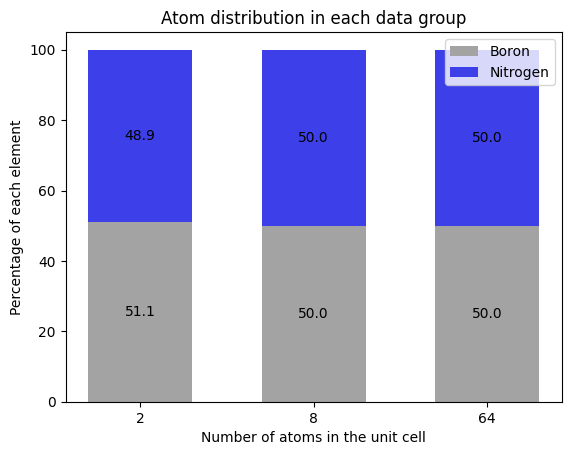

In [108]:
import numpy as np

species = ('2', '8', '64')
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(3)

colors = {
    'Boron': '#A4A3A3',
    'Nitrogen': "#3D40E9"
}


for n_atoms, count in type_percent.items():
    p = ax.bar(species, count, width, label=n_atoms, bottom=bottom, color=colors.get(n_atoms, 'black'))
    bottom += count

    ax.bar_label(p, label_type='center', fmt='%.1f')

plt.xlabel("Number of atoms in the unit cell")
plt.ylabel("Percentage of each element")
plt.title("Atom distribution in each data group")
ax.legend()

plt.show()